In [55]:
# Step 1 Load Hackathon Training and Testing Datasets

# In this project, we analyze well log data from the Hackathon dataset to develop a machine learning model for automated washout detection. The logs are divided into a training set (hackathon_train.csv) and a test set (hackathon_test.csv). We begin by importing both files from Google Drive.

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File paths
train_path = '/content/drive/My Drive/Msc Final Year Project/hackathon_train.csv'
test_path = '/content/drive/My Drive/Msc Final Year Project/hackathon_test.csv'

# Load CSV files
import pandas as pd
hackathon_train = pd.read_csv(train_path)
hackathon_test = pd.read_csv(test_path)

# Define a default directory
SAVE_DIR = '/content/drive/My Drive/Msc Final Year Project/'

def save_plot(fig, filename):
    full_path = SAVE_DIR + filename
    fig.savefig(full_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {full_path}")

# Preview the training data
hackathon_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
0,0,14121.660105,89.6461,NaN,NaN,9.9048,2.5777,NaN,88.8573,0.277790,NaN,2.6310,2.4927,NaN,0.0,1.0,0.751631
1,0,14122.160105,96.0152,NaN,NaN,9.9912,2.4748,NaN,120.8949,0.294806,NaN,2.4760,2.4685,NaN,0.0,1.0,1.032475
2,0,14122.660105,104.0457,NaN,NaN,9.9048,2.3338,NaN,153.5195,0.447361,NaN,2.4359,2.3742,NaN,0.0,1.0,1.312757
3,0,14123.160105,113.5010,NaN,NaN,9.9048,2.2358,NaN,182.8531,0.579637,NaN,2.4065,2.4142,NaN,0.0,1.0,1.682292
4,0,14123.660105,117.7817,NaN,NaN,9.8095,2.2278,NaN,256.1960,0.556317,NaN,2.3365,2.4077,NaN,0.0,1.0,1.924398


Visualizing Missing Values (Before Any Cleaning)

To understand the structure and completeness of the dataset before any preprocessing, we plot a heatmap showing missing values across all features in the raw training set.

✅ Saved: /content/drive/My Drive/Msc Final Year Project/Missing Values in hackathon_train.png


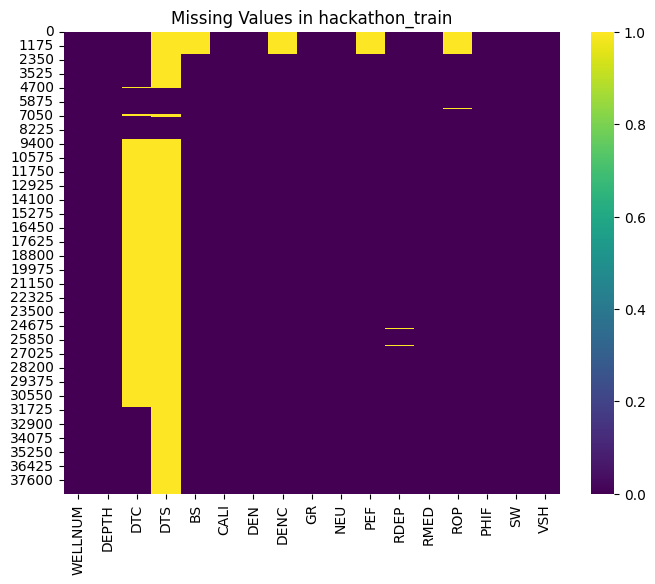

In [56]:
# Visualize missing values BEFORE any cleaning
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(hackathon_train.isnull(), cbar=True, cmap='viridis')
plt.title("Missing Values in hackathon_train")

# Save using helper function
save_plot(plt, "Missing Values in hackathon_train.png")
plt.show()


Step 2: Clean Data and KNN Imputation for Missing Values

To ensure data quality, we drop Well 0 entirely as it contains excessive missing or unreliable values. We also select a set of logs that are available across most wells, dropping rows with missing values in these features.

Instead of removing rows with missing values, we use K-Nearest Neighbors (KNN) imputation to fill them. This helps preserve data and ensures that intervals with minor gaps can still contribute to the model. We apply the imputer on key features including the selected logs and borehole measurements like CALI and BS.

In [57]:
# Drop WELLNUM 0
hackathon_train = hackathon_train[hackathon_train['WELLNUM'] != 0].copy()

from sklearn.impute import KNNImputer
import pandas as pd

# Select columns to impute
log_features = ['GR', 'DEN', 'NEU', 'RDEP', 'PEF', 'PHIF', 'CALI', 'BS']

# Copy only the log features for imputation
impute_df = hackathon_train[log_features].copy()

# Reset index to avoid alignment problems when reassigning
impute_df_reset = impute_df.reset_index(drop=True)

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=10)
imputed_array = imputer.fit_transform(impute_df_reset)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_array, columns=log_features)

# Replace values in hackathon_train
hackathon_train.loc[:, log_features] = imputed_df.values

# Confirm it's clean
print("✅ Missing values after KNN imputation:")
print(hackathon_train[log_features].isnull().sum())

✅ Missing values after KNN imputation:
GR      0
DEN     0
NEU     0
RDEP    0
PEF     0
PHIF    0
CALI    0
BS      0
dtype: int64


Step 4: Define RATIO and Label QUALITY_FACTOR

To identify washout intervals, we calculate the ratio between caliper (CALI) and bit size (BS) at each depth. Intervals where the ratio is between 0.98 and 1.02 are considered good quality. Intervals outside this range may indicate borehole enlargement or washout, and are labeled as bad quality.

This threshold-based approach allows us to define a binary classification target called QUALITY_FACTOR.

In [58]:
# Compute RATIO
hackathon_train['RATIO'] = hackathon_train['CALI'] / hackathon_train['BS']

# Apply corrected logic: 0 = good, 1 = bad
hackathon_train['QUALITY_FACTOR'] = hackathon_train['RATIO'].apply(
    lambda x: 0 if 0.98 <= x <= 1.02 else 1
)

# Show proportion of bad data
bad_ratio = (hackathon_train['QUALITY_FACTOR'] == 1).mean()
print(f"✅ Proportion of BAD data (QUALITY_FACTOR = 1): {bad_ratio:.4f}")
print("✅ Final dataset shape:", hackathon_train.shape)

✅ Proportion of BAD data (QUALITY_FACTOR = 1): 0.2882
✅ Final dataset shape: (36879, 19)


✅ Saved: /content/drive/My Drive/Msc Final Year Project/RATIO_distribution.png


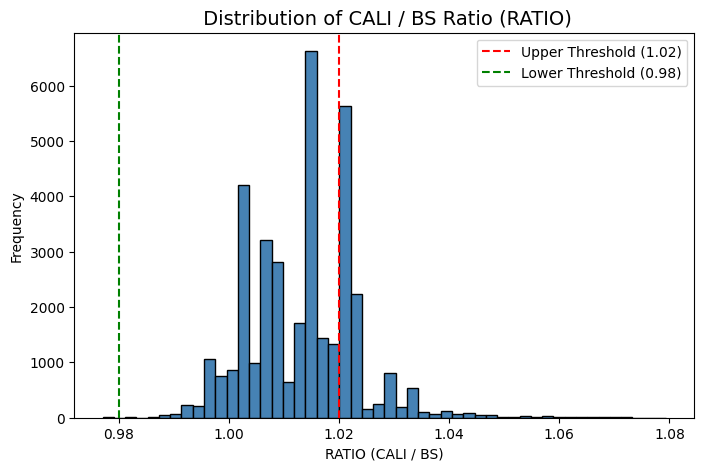

In [59]:
import matplotlib.pyplot as plt

# Histogram of RATIO
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(hackathon_train['RATIO'], bins=50, color='steelblue', edgecolor='black')
ax.axvline(1.02, color='red', linestyle='--', label='Upper Threshold (1.02)')
ax.axvline(0.98, color='green', linestyle='--', label='Lower Threshold (0.98)')
ax.set_title(' Distribution of CALI / BS Ratio (RATIO)', fontsize=14)
ax.set_xlabel('RATIO (CALI / BS)')
ax.set_ylabel('Frequency')
ax.legend()

# Save and show
save_plot(fig, 'RATIO_distribution.png')
plt.show()

✅ Saved: /content/drive/My Drive/Msc Final Year Project/QUALITY_FACTOR_piechart.png


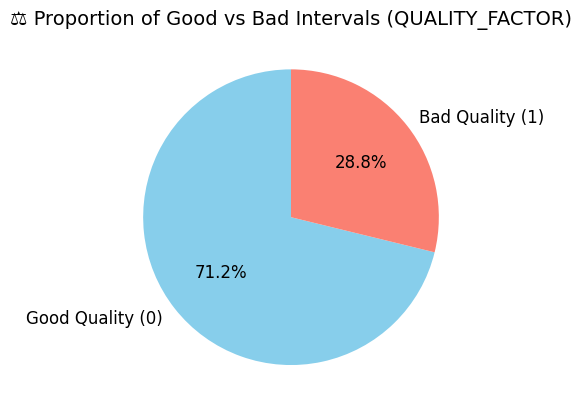

In [60]:
# Pie chart of QUALITY_FACTOR
fig, ax = plt.subplots()
hackathon_train['QUALITY_FACTOR'].value_counts().plot.pie(
    labels=['Good Quality (0)', 'Bad Quality (1)'],
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    ax=ax,
    startangle=90,
    textprops={'fontsize': 12}
)
ax.set_ylabel('')
ax.set_title('⚖️ Proportion of Good vs Bad Intervals (QUALITY_FACTOR)', fontsize=14)

# Save and show
save_plot(fig, 'QUALITY_FACTOR_piechart.png')
plt.show()


✅ Saved: /content/drive/My Drive/Msc Final Year Project/RATIO_boxplot_by_quality.png


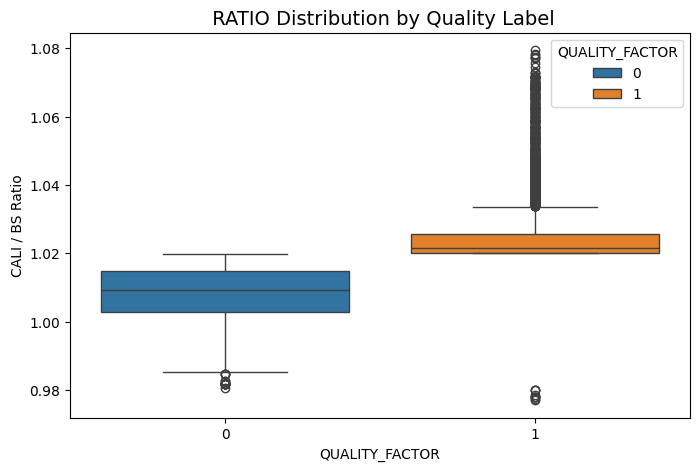

In [61]:
import seaborn as sns

# Boxplot of RATIO grouped by QUALITY_FACTOR
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=hackathon_train, x='QUALITY_FACTOR', y='RATIO', hue='QUALITY_FACTOR', ax=ax)
ax.set_title(' RATIO Distribution by Quality Label', fontsize=14)
ax.set_xlabel('QUALITY_FACTOR')
ax.set_ylabel('CALI / BS Ratio')

# Save and show
save_plot(fig, 'RATIO_boxplot_by_quality.png')
plt.show()


Step 5: Outlier Detection with Isolation Forest

While RATIO provides a threshold-based flag for borehole enlargement, we also apply an unsupervised machine learning technique — Isolation Forest — to identify anomalous intervals across multiple well logs.

Isolation Forest works by randomly partitioning the data and identifying points that are easier to isolate, which typically correspond to outliers. This step provides a second quality control layer that captures multivariate anomalies.

In [62]:
from sklearn.preprocessing import StandardScaler

# Select features (no CALI or BS to avoid leakage)
isofeatures = ['GR', 'DEN', 'NEU', 'RDEP', 'PEF', 'PHIF']

# Extract features for Isolation Forest
X_iso = hackathon_train[isofeatures].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_iso)


In [63]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.0415,  # Estimate: 4.15% of data is anomalous
    random_state=42
)

# Fit the model and predict outliers
iso_preds = iso_model.fit_predict(X_scaled)


In [64]:
from sklearn.metrics import confusion_matrix, classification_report

# Convert predictions to match QUALITY_FACTOR: 1 = bad, 0 = good
iso_labels = (iso_preds == -1).astype(int)

# Compare with actual QUALITY_FACTOR
y_true = hackathon_train['QUALITY_FACTOR']


# Evaluation
print("📊 Confusion Matrix (Isolation Forest vs QUALITY_FACTOR):\n", confusion_matrix(y_true, iso_labels))
print("\n📋 Classification Report (Isolation Forest vs QUALITY_FACTOR):\n", classification_report(y_true, iso_labels, target_names=["Good (0)", "Bad (1)"]))


📊 Confusion Matrix (Isolation Forest vs QUALITY_FACTOR):
 [[25674   578]
 [ 9674   953]]

📋 Classification Report (Isolation Forest vs QUALITY_FACTOR):
               precision    recall  f1-score   support

    Good (0)       0.73      0.98      0.83     26252
     Bad (1)       0.62      0.09      0.16     10627

    accuracy                           0.72     36879
   macro avg       0.67      0.53      0.50     36879
weighted avg       0.70      0.72      0.64     36879



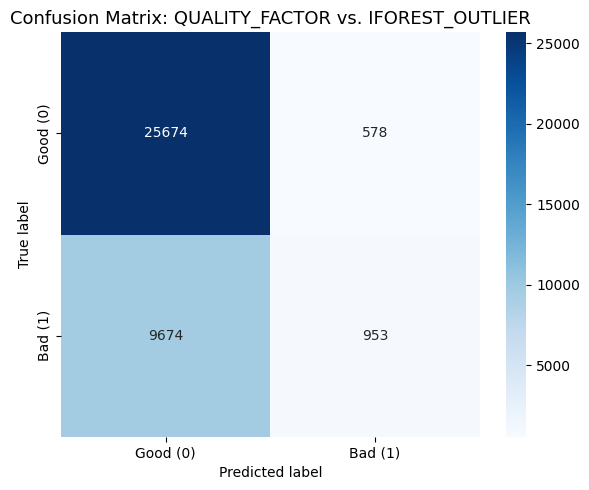

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Reuse y_true and iso_labels from earlier step
cm = confusion_matrix(y_true, iso_labels)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=["Good (0)", "Bad (1)"],
            yticklabels=["Good (0)", "Bad (1)"])

plt.title("Confusion Matrix: QUALITY_FACTOR vs. IFOREST_OUTLIER", fontsize=13)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


**Tuning Contamination Parameter in Isolation Forest**

Before selecting the final unsupervised model for detecting poor-quality intervals, we explore how different values of the contamination parameter affect Isolation Forest performance.

The contamination parameter informs the algorithm of the expected proportion of outliers in the dataset. Since this is an unsupervised method, the actual label (QUALITY_FACTOR) is not used during training. However, we compare the model predictions with the QUALITY_FACTOR afterward to evaluate how well the outlier detection aligns with known poor-quality intervals.

In this step, we test a range of contamination values: [0.04, 0.10, 0.15, 0.20, 0.26]
For each case, we:

Train an Isolation Forest
Predict outliers
Compare predictions to QUALITY_FACTOR
Record key performance metrics: Precision, Recall, F1-score, and Confusion Matrix
The goal is to identify the contamination level that best captures the true "bad" data (QUALITY_FACTOR = 1), especially prioritizing recall (sensitivity to poor-quality intervals).

In [66]:
from sklearn.metrics import precision_score, recall_score, f1_score

contamination_values = [0.04, 0.10, 0.15, 0.20, 0.26]

print("Contamination | Precision (1) | Recall (1) | F1-Score (1)")
print("---------------------------------------------------------")

for cont in contamination_values:
    iso_model = IsolationForest(n_estimators=100, contamination=cont, random_state=42)
    preds = iso_model.fit_predict(X_scaled)
    outlier_labels = (preds == -1).astype(int)  # 1 = anomaly

    # Evaluate against true bad wells
    precision = precision_score(y_true, outlier_labels, pos_label=1)
    recall = recall_score(y_true, outlier_labels, pos_label=1)
    f1 = f1_score(y_true, outlier_labels, pos_label=1)

    print(f"{cont:<13} | {precision:>12.2f} | {recall:>9.2f} | {f1:>10.2f}")


Contamination | Precision (1) | Recall (1) | F1-Score (1)
---------------------------------------------------------
0.04          |         0.63 |      0.09 |       0.15
0.1           |         0.51 |      0.18 |       0.26
0.15          |         0.44 |      0.23 |       0.30
0.2           |         0.40 |      0.28 |       0.33
0.26          |         0.36 |      0.33 |       0.34


Now that we have ve identified 0.26 as the optimal contamination value, we proceed to tune the n_estimators parameter of the Isolation Forest model. This parameter determines the number of base estimators (trees) used to isolate anomalies. Higher values may improve stability but also increase computation time. We will evaluate multiple values to identify which configuration best balances performance for detecting bad data (QUALITY_FACTOR = 1).

In [67]:
n_estimators_range = [50, 100, 150, 200, 250]

print("n_estimators | Precision (1) | Recall (1) | F1-Score (1)")
print("--------------------------------------------------------")

for n in n_estimators_range:
    iso_model = IsolationForest(n_estimators=n, contamination=0.26, random_state=42)
    preds = iso_model.fit_predict(X_scaled)
    outlier_labels = (preds == -1).astype(int)

    precision = precision_score(y_true, outlier_labels, pos_label=1)
    recall = recall_score(y_true, outlier_labels, pos_label=1)
    f1 = f1_score(y_true, outlier_labels, pos_label=1)

    print(f"{n:<13} | {precision:>12.2f} | {recall:>9.2f} | {f1:>10.2f}")


n_estimators | Precision (1) | Recall (1) | F1-Score (1)
--------------------------------------------------------
50            |         0.35 |      0.32 |       0.33
100           |         0.36 |      0.33 |       0.34
150           |         0.36 |      0.33 |       0.35
200           |         0.36 |      0.33 |       0.35
250           |         0.37 |      0.33 |       0.35


In [68]:
# Fit final Isolation Forest model with selected parameters
final_iso = IsolationForest(n_estimators=200, contamination=0.26, random_state=42)
final_preds = final_iso.fit_predict(X_scaled)

# Convert to binary labels
hackathon_train['IFOREST_OUTLIER'] = (final_preds == -1).astype(int)


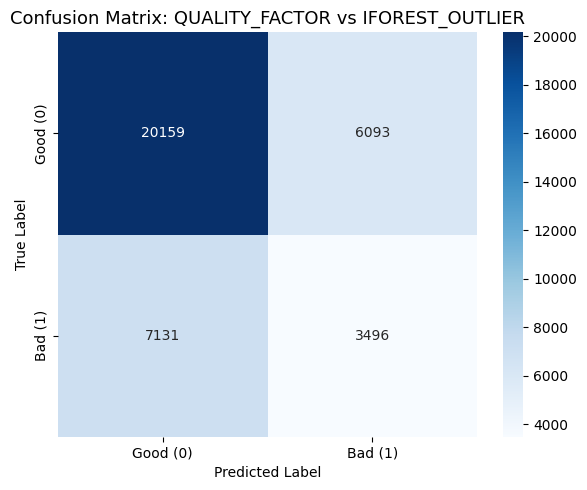

In [69]:
# Confusion matrix using final labels
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(hackathon_train['QUALITY_FACTOR'], hackathon_train['IFOREST_OUTLIER'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=["Good (0)", "Bad (1)"],
            yticklabels=["Good (0)", "Bad (1)"])

plt.title("Confusion Matrix: QUALITY_FACTOR vs IFOREST_OUTLIER", fontsize=13)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


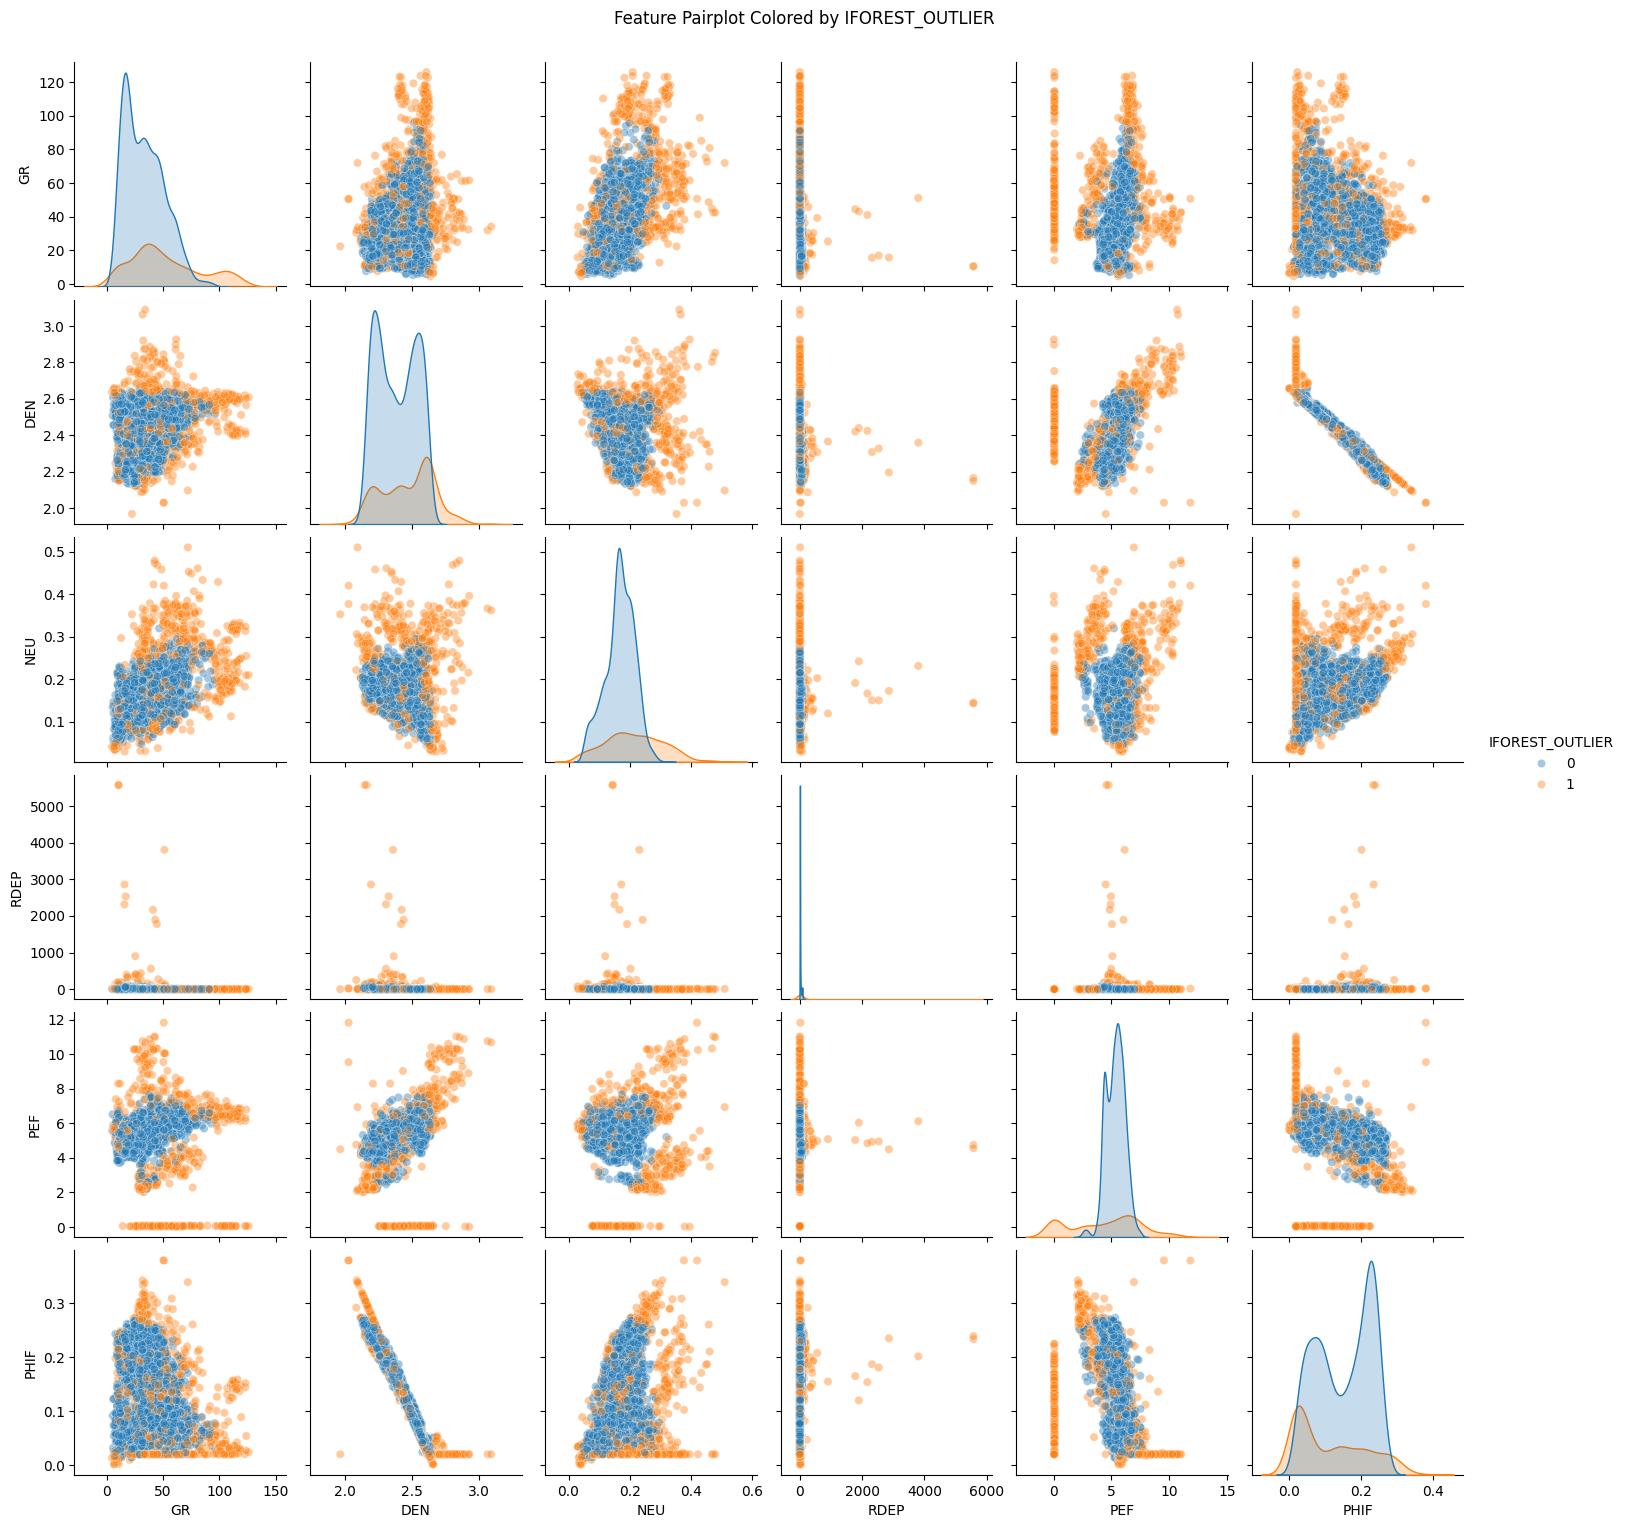

In [70]:
# Sample a subset for clearer visualization
sampled = hackathon_train.sample(3000, random_state=42)

# Pairplot using Isolation Forest features
sns.pairplot(
    sampled,
    vars=isofeatures,
    hue='IFOREST_OUTLIER',
    plot_kws={'alpha': 0.4}
)

plt.suptitle("Feature Pairplot Colored by IFOREST_OUTLIER", y=1.02)
plt.savefig(SAVE_DIR + 'IFOREST_pairplot_features.png', dpi=300, bbox_inches='tight')
plt.show()


✅ Saved: /content/drive/My Drive/Msc Final Year Project/IFOREST_scatter_ratio_depth_by_well.png


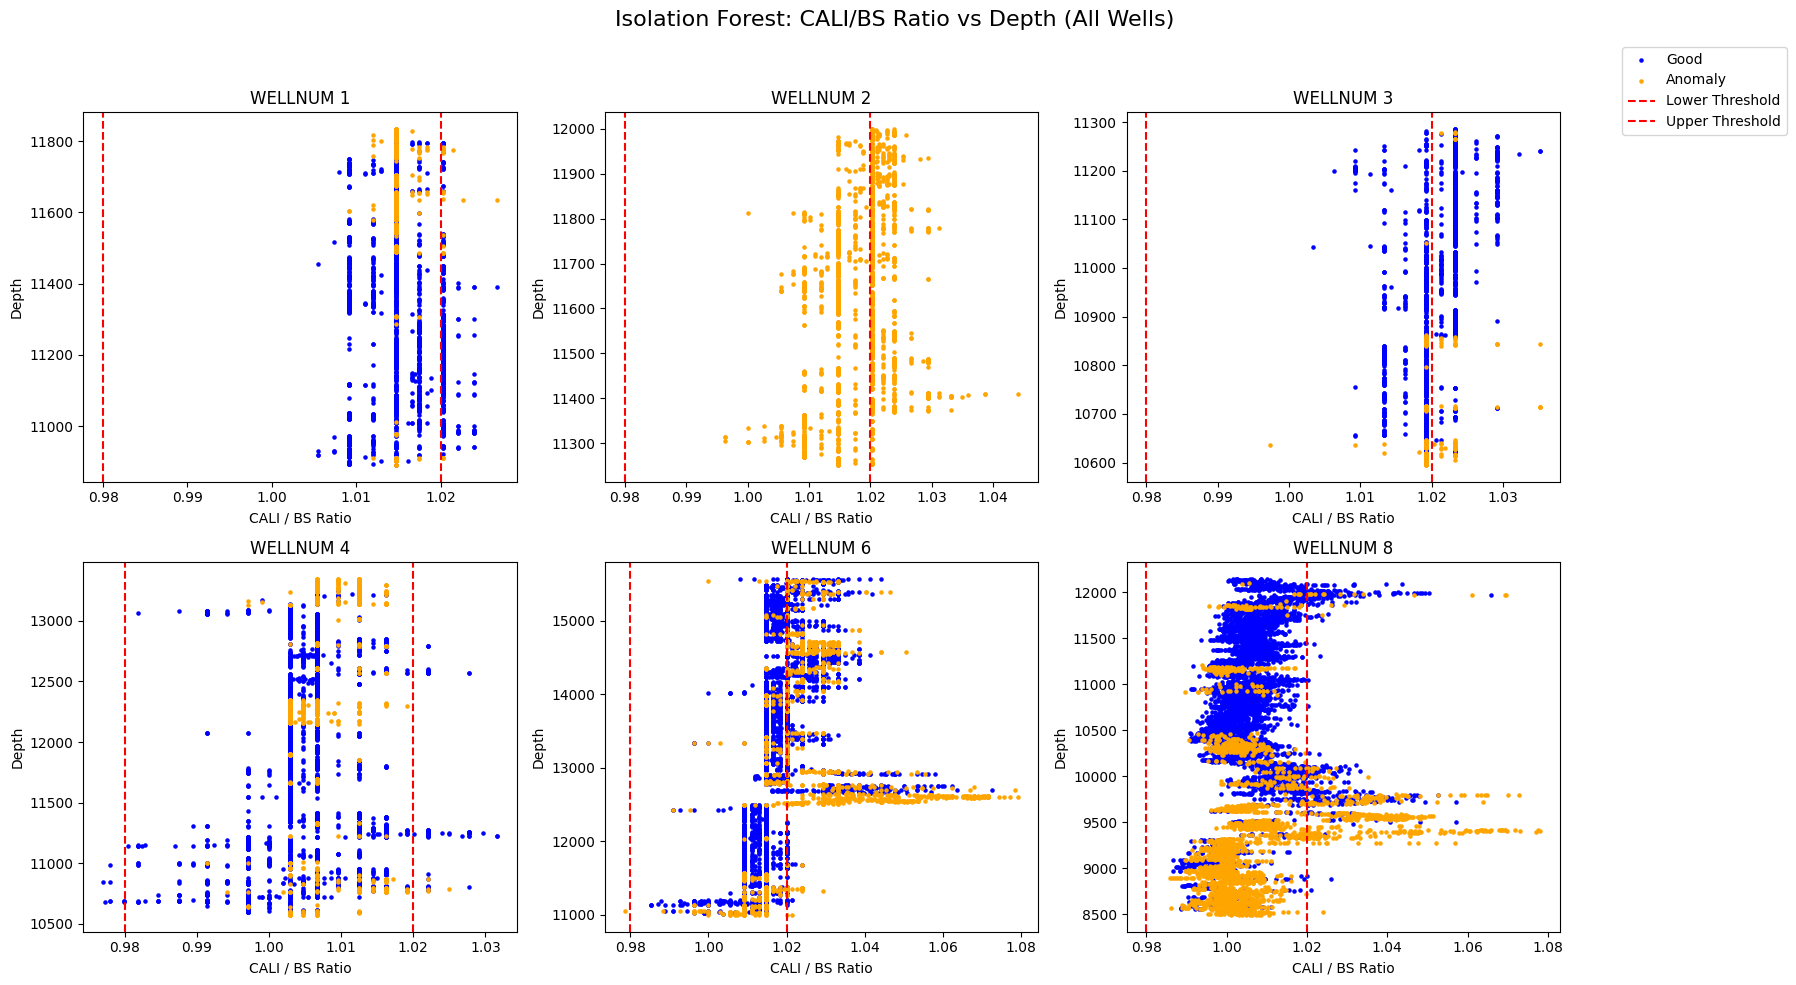

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Ensure RATIO is computed (if not already)
hackathon_train['RATIO'] = hackathon_train['CALI'] / hackathon_train['BS']

# ✅ Setup: Get all unique wells
unique_wells = hackathon_train['WELLNUM'].unique()
num_wells = len(unique_wells)

# ✅ Create 2x3 subplot layout (for up to 6 wells)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=False, sharey=False)
axes = axes.flatten()

# ✅ Plot Isolation Forest anomalies well-by-well
for i, well in enumerate(unique_wells):
    if i >= len(axes): break  # Stop if we run out of axes

    ax = axes[i]
    well_data = hackathon_train[hackathon_train['WELLNUM'] == well]

    # Separate inliers and outliers
    good = well_data[well_data['IFOREST_OUTLIER'] == 0]
    anomaly = well_data[well_data['IFOREST_OUTLIER'] == 1]

    # Scatter plot: RATIO vs DEPTH
    ax.scatter(good['RATIO'], good['DEPTH'], s=5, color='blue', label='Good')
    ax.scatter(anomaly['RATIO'], anomaly['DEPTH'], s=5, color='orange', label='Anomaly')

    # Labels and title
    ax.set_title(f"WELLNUM {int(well)}", fontsize=12)
    ax.set_xlabel("CALI / BS Ratio")
    ax.set_ylabel("Depth")

    # Add vertical threshold lines for 0.98 and 1.02
    ax.axvline(x=0.98, color='red', linestyle='--', label='Lower Threshold' if i == 0 else "")
    ax.axvline(x=1.02, color='red', linestyle='--', label='Upper Threshold' if i == 0 else "")

# ✅ Shared legend (based on first subplot only)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.95))

# ✅ Save and show
save_plot(fig, 'IFOREST_scatter_ratio_depth_by_well.png')

plt.suptitle("Isolation Forest: CALI/BS Ratio vs Depth (All Wells)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.88, 0.95])
plt.show()


 **Isolation Forest Depth-Ratio Visualization**

To evaluate how Isolation Forest anomaly predictions align with borehole quality thresholds and depth:

- A `scatterplot` was created for each well showing the relationship between **CALI/BS ratio** and **DEPTH**
- Points were colored based on Isolation Forest predictions:
  - 🔵 `0` = Good (inlier)
  - 🟠 `1` = Bad (outlier)
- Red dashed lines indicate the borehole integrity thresholds at `0.98` and `1.02`
- This visualization helps verify whether detected anomalies occur outside acceptable physical limits or reveal hidden issues

📁 Saved as: `IFOREST_scatter_ratio_depth_by_well.png`


### Isolation Forest Summary

- **Algorithm:** Unsupervised anomaly detection using Isolation Forest
- **Features Used:** GR, DEN, NEU, RDEP, PEF, PHIF (excluding CALI/BS to avoid leakage)
- **Contamination:** 0.26 (estimated proportion of anomalies)
- **n_estimators:** 200
- **Label Conversion:** -1 → 1 (outlier/bad), 1 → 0 (inlier/good)
- **Evaluation Against QUALITY_FACTOR:**
    - **Precision (Bad):** 0.36
    - **Recall (Bad):** 0.33
    - **F1-Score (Bad):** 0.35
- **Conclusion:** The model provides moderate recall for detecting BAD borehole zones using only unsupervised signal patterns, serving as a lightweight quality control layer before supervised learning (XGBoost).


**XGBoost Supervised Classification**



In [72]:
# Define clean features and label (exclude CALI and BS to avoid leakage)
features = ['GR', 'DEN', 'NEU', 'RDEP', 'PEF', 'PHIF']
X = hackathon_train[features]
y = hackathon_train['QUALITY_FACTOR']
print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)
print("\n✅ Feature sample:\n", X.head())
print("\n✅ Label counts:\n", y.value_counts())



✅ X shape: (36879, 6)
✅ y shape: (36879,)

✅ Feature sample:
             GR     DEN     NEU    RDEP     PEF    PHIF
1880  129.3430  2.6320  0.1098  1.4653  7.3906  0.0200
1881   94.6083  2.6426  0.1054  1.5041  7.0966  0.0200
1882   72.5098  2.6377  0.1051  1.7396  6.7806  0.0200
1883   58.2253  2.6181  0.1047  1.9329  6.4906  0.0238
1884   52.7181  2.5873  0.1061  1.9650  6.2785  0.0413

✅ Label counts:
 QUALITY_FACTOR
0    26252
1    10627
Name: count, dtype: int64


**Why Well-Based Splitting?**

We simulate realistic deployment conditions by training the model on logs from wells 1, 2, 3, 4, and 8, and validating on a completely held-out well (WELLNUM 6). This mimics real-world usage where the model must generalize to unseen wells with different lithologies or tool responses.

In [73]:
# Split by WELLNUM: use WELLNUM 6 for validation, rest for training
val_well = 6

X_val = hackathon_train[hackathon_train['WELLNUM'] == val_well][features]
y_val = hackathon_train[hackathon_train['WELLNUM'] == val_well]['QUALITY_FACTOR']

X_train = hackathon_train[hackathon_train['WELLNUM'] != val_well][features]
y_train = hackathon_train[hackathon_train['WELLNUM'] != val_well]['QUALITY_FACTOR']


**Balancing the Training Set with SMOTE**

Due to class imbalance in the QUALITY_FACTOR label (fewer bad data points), we applied SMOTE (Synthetic Minority Over-sampling Technique) to the training set only. This balances the dataset by generating synthetic examples of the minority class, improving the model’s ability to detect bad-quality data without leaking synthetic samples into validation or test wells.

In [74]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with fixed random_state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE to training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
import numpy as np
unique, counts = np.unique(y_train_resampled, return_counts=True)
print("✅ Class distribution after SMOTE:", dict(zip(unique, counts)))


✅ Class distribution after SMOTE: {np.int64(0): np.int64(19112), np.int64(1): np.int64(19112)}


**Training XGBoost on Balanced Data**

With SMOTE-balanced training data, we train an XGBoost model to classify well log intervals as good or bad quality. The model is evaluated on a real, unbalanced validation well (WELLNUM 6) to check how well it generalizes. Metrics like precision, recall, and F1-score for the bad class are critical in this quality control context.

In [75]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Step 3: Define and train the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # SMOTE already handled balance
    eval_metric='logloss',
    random_state=42
)



xgb_model.fit(X_train_resampled, y_train_resampled)

# ✅ Predict on validation well (WELLNUM 6)
y_val_pred = xgb_model.predict(X_val)


# ✅ Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred, target_names=['Good (0)', 'Bad (1)']))

Confusion Matrix:
 [[7045   95]
 [6298  495]]

Classification Report:
               precision    recall  f1-score   support

    Good (0)       0.53      0.99      0.69      7140
     Bad (1)       0.84      0.07      0.13      6793

    accuracy                           0.54     13933
   macro avg       0.68      0.53      0.41     13933
weighted avg       0.68      0.54      0.42     13933



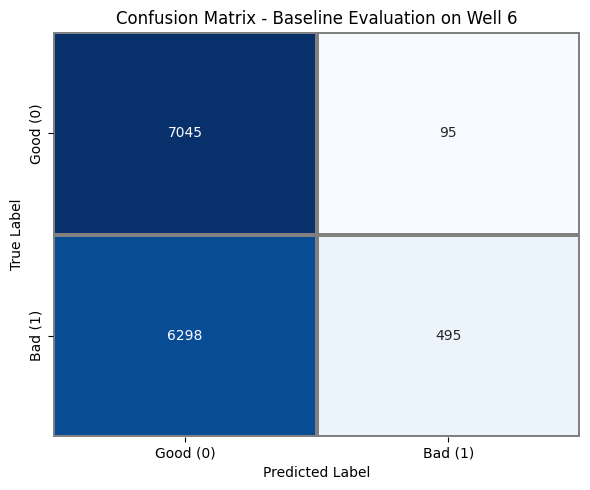

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
labels = ['Good (0)', 'Bad (1)']

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, linewidths=1.5, linecolor='gray')
plt.title('Confusion Matrix - Baseline Evaluation on Well 6')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


**Hyperparameter Tuning (Grid Search) for XGBoost**

To improve supervised classification performance, we perform a small grid search over key XGBoost hyperparameters. Because we balanced the training data using SMOTE, we do not adjust scale_pos_weight in this tuning round.

Validation Strategy:
Training on wells 1, 2, 3, 4, and 8 (SMOTE-balanced).
Validating on held-out Well 6 (untouched, real class balance).

Metric of Interest:
We prioritize F1-score for the Bad class (QUALITY_FACTOR = 1) because detecting poor-quality intervals is more important than overall accuracy.

Grid tested:

max_depth: [4, 6, 8]
learning_rate: [0.1, 0.05, 0.025]
n_estimators: [200, 400]
subsample: 0.8 (fixed)
colsample_bytree: 0.8 (fixed)
scale_pos_weight: 1 (SMOTE used)

Each parameter combination was trained and evaluated on the validation set, and the results were ranked based on the F1-score of the Bad class. The optimal configuration was then selected for further refinement.



In [77]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import itertools
import pandas as pd

# Define grid search space
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.1, 0.05, 0.025],
    'n_estimators': [200, 400],
}

# Fixed hyperparameters
fixed_params = {
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,  # SMOTE handled class balance
    'eval_metric': 'logloss',
    'random_state': 42,
    'use_label_encoder': False
}

# Store results
grid_results = []

# Grid search over all combinations
for md, lr, ne in itertools.product(param_grid['max_depth'],
                                    param_grid['learning_rate'],
                                    param_grid['n_estimators']):

    # Combine fixed and test-specific parameters
    params = dict(fixed_params)
    params.update({
        'max_depth': md,
        'learning_rate': lr,
        'n_estimators': ne
    })

    # Train model
    model = XGBClassifier(**params)
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on validation set (Well 6)
    y_val_pred = model.predict(X_val)

    # Compute class 1 (Bad) metrics
    prec_bad = precision_score(y_val, y_val_pred, pos_label=1)
    rec_bad  = recall_score(y_val, y_val_pred, pos_label=1)
    f1_bad   = f1_score(y_val, y_val_pred, pos_label=1)

    # Store result
    grid_results.append({
        'max_depth': md,
        'learning_rate': lr,
        'n_estimators': ne,
        'Precision_Bad': prec_bad,
        'Recall_Bad': rec_bad,
        'F1_Bad': f1_bad
    })

    print(f"Tested md={md}, lr={lr}, ne={ne} --> F1_Bad={f1_bad:.4f}, Recall={rec_bad:.4f}, Precision={prec_bad:.4f}")

# Convert to DataFrame
grid_df = pd.DataFrame(grid_results).sort_values(by='F1_Bad', ascending=False).reset_index(drop=True)

# Display top combinations
print("\n📊 Top grid results (sorted by F1_Bad):")
display(grid_df.head())


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:35:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.1, ne=200 --> F1_Bad=0.1293, Recall=0.0701, Precision=0.8380


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.1, ne=400 --> F1_Bad=0.1232, Recall=0.0668, Precision=0.7882


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.05, ne=200 --> F1_Bad=0.1840, Recall=0.1030, Precision=0.8600


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.05, ne=400 --> F1_Bad=0.1237, Recall=0.0668, Precision=0.8285


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.025, ne=200 --> F1_Bad=0.2216, Recall=0.1270, Precision=0.8656


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.025, ne=400 --> F1_Bad=0.1811, Recall=0.1014, Precision=0.8464


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.1, ne=200 --> F1_Bad=0.0813, Recall=0.0428, Precision=0.7973


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.1, ne=400 --> F1_Bad=0.0746, Recall=0.0392, Precision=0.7778


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.05, ne=200 --> F1_Bad=0.1141, Recall=0.0612, Precision=0.8303


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.05, ne=400 --> F1_Bad=0.0997, Recall=0.0530, Precision=0.8353


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.025, ne=200 --> F1_Bad=0.1424, Recall=0.0777, Precision=0.8489


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.025, ne=400 --> F1_Bad=0.1105, Recall=0.0593, Precision=0.8092


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.1, ne=200 --> F1_Bad=0.0840, Recall=0.0443, Precision=0.8091


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.1, ne=400 --> F1_Bad=0.0749, Recall=0.0393, Precision=0.7923


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.05, ne=200 --> F1_Bad=0.0894, Recall=0.0473, Precision=0.8338


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.05, ne=400 --> F1_Bad=0.0714, Recall=0.0374, Precision=0.7913


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.025, ne=200 --> F1_Bad=0.1162, Recall=0.0624, Precision=0.8396


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.025, ne=400 --> F1_Bad=0.0838, Recall=0.0442, Precision=0.8108

📊 Top grid results (sorted by F1_Bad):


,max_depth,learning_rate,n_estimators,Precision_Bad,Recall_Bad,F1_Bad
0,4,0.025,200,0.865597,0.127043,0.221566
1,4,0.050,200,0.859951,0.103047,0.184041
2,4,0.025,400,0.846437,0.101428,0.181149
3,6,0.025,200,0.848875,0.077727,0.142414
4,4,0.100,200,0.838028,0.070072,0.129330


✅ Saved: /content/drive/My Drive/Msc Final Year Project/XGB_GridSearch_Summary.png


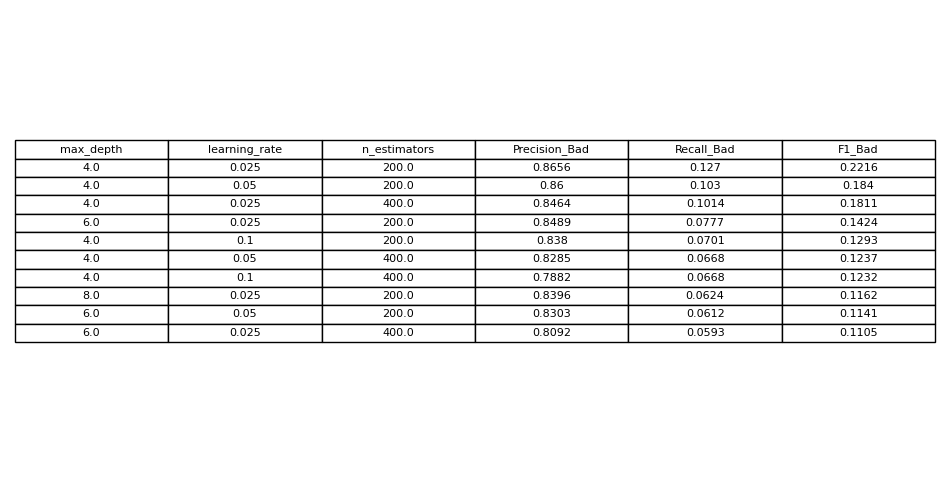

In [78]:
import matplotlib.pyplot as plt

# Save table as image (Top 10 rows only)
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')  # hide axes

# Use ax.table instead of importing table directly
tbl = ax.table(
    cellText=grid_df.head(10).round(4).values,
    colLabels=grid_df.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.15]*len(grid_df.columns)
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.1, 1.1)

# Save and show
save_plot(fig, 'XGB_GridSearch_Summary.png')
plt.show()


In [79]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.025,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # No need to adjust since data is balanced by SMOTE
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# Train the model
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on training set
y_train_pred = xgb_model.predict(X_train_resampled)

# Evaluate on training set
print("📊 Confusion Matrix (Training Set):\n", confusion_matrix(y_train_resampled, y_train_pred))
print("\n📋 Classification Report (Training Set):\n", classification_report(y_train_resampled, y_train_pred, target_names=["Good (0)", "Bad (1)"]))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Confusion Matrix (Training Set):
 [[16299  2813]
 [ 2160 16952]]

📋 Classification Report (Training Set):
               precision    recall  f1-score   support

    Good (0)       0.88      0.85      0.87     19112
     Bad (1)       0.86      0.89      0.87     19112

    accuracy                           0.87     38224
   macro avg       0.87      0.87      0.87     38224
weighted avg       0.87      0.87      0.87     38224



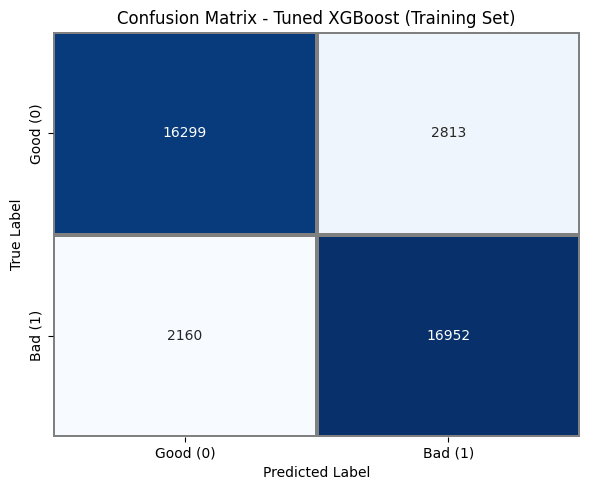

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix from training predictions
cm_train = confusion_matrix(y_train_resampled, y_train_pred)

# Define class labels
labels = ['Good (0)', 'Bad (1)']

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, linewidths=1.5, linecolor='gray')
plt.title('Confusion Matrix - Tuned XGBoost (Training Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [81]:
# Predict on the validation well
y_val_pred = xgb_model.predict(X_val)

# Evaluate predictions on WELLNUM 6
print("📊 Confusion Matrix (Validation Set):\n", confusion_matrix(y_val, y_val_pred))
print("\n📋 Classification Report (Validation Set):\n", classification_report(y_val, y_val_pred, target_names=["Good (0)", "Bad (1)"]))


📊 Confusion Matrix (Validation Set):
 [[7006  134]
 [5930  863]]

📋 Classification Report (Validation Set):
               precision    recall  f1-score   support

    Good (0)       0.54      0.98      0.70      7140
     Bad (1)       0.87      0.13      0.22      6793

    accuracy                           0.56     13933
   macro avg       0.70      0.55      0.46     13933
weighted avg       0.70      0.56      0.47     13933



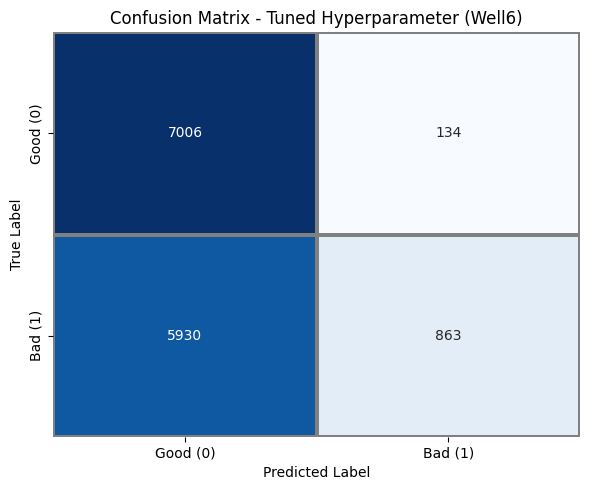

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Manually input the confusion matrix for the validation set
cm_val = np.array([[7006, 134],
                   [5930, 863]])

# Define class labels
labels = ['Good (0)', 'Bad (1)']

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, linewidths=1.5, linecolor='gray')
plt.title('Confusion Matrix - Tuned Hyperparameter (Well6)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


**Threshold Tuning and Class Imbalance Handling**

While the grid search helped identify a strong base model, the default decision threshold of 0.5 often fails to reflect the real-world asymmetry in misclassification costs. Therefore, the next step involved threshold tuning—adjusting the probability cutoff to improve sensitivity toward the Bad class, especially under class imbalance.

This process helps fine-tune the model’s decision boundary to ensure that the classifier prioritizes quality issues appropriately, even if it means accepting a slightly lower precision in exchange for higher recall or F1-score for the minority class.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Threshold = 0.10 --> Precision: 0.57, Recall: 0.75, F1: 0.64
Threshold = 0.20 --> Precision: 0.74, Recall: 0.50, F1: 0.60
Threshold = 0.25 --> Precision: 0.76, Recall: 0.45, F1: 0.56
Threshold = 0.30 --> Precision: 0.80, Recall: 0.38, F1: 0.51
Threshold = 0.40 --> Precision: 0.82, Recall: 0.24, F1: 0.37
Threshold = 0.50 --> Precision: 0.87, Recall: 0.13, F1: 0.22
Threshold = 0.60 --> Precision: 0.89, Recall: 0.04, F1: 0.07
Threshold = 0.65 --> Precision: 0.93, Recall: 0.02, F1: 0.04
Threshold = 0.70 --> Precision: 0.93, Recall: 0.01, F1: 0.02


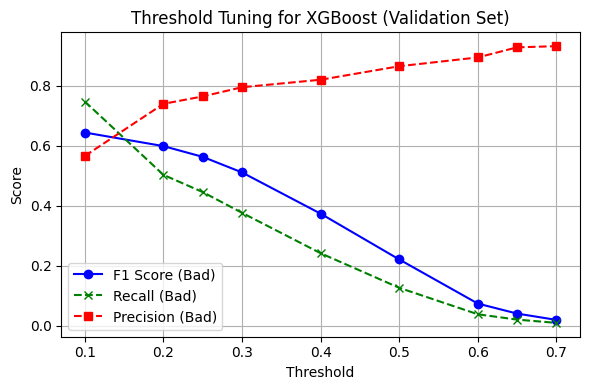

In [83]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Best parameters from grid search
best_xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.025,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # SMOTE used
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# Train model on SMOTE-balanced data
best_xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on validation set (e.g., Well 6)
y_val_proba = best_xgb_model.predict_proba(X_val)[:, 1]

# Thresholds to evaluate
thresholds = [0.10, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7]

threshold_results = []

for thresh in thresholds:
    y_val_thresh = (y_val_proba >= thresh).astype(int)

    prec = precision_score(y_val, y_val_thresh, pos_label=1)
    rec = recall_score(y_val, y_val_thresh, pos_label=1)
    f1 = f1_score(y_val, y_val_thresh, pos_label=1)

    threshold_results.append({
        'Threshold': thresh,
        'Precision_Bad': prec,
        'Recall_Bad': rec,
        'F1_Bad': f1
    })

    print(f"Threshold = {thresh:.2f} --> Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")

# Save as DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Save as CSV
threshold_df.to_csv(SAVE_DIR + 'XGB_Threshold_Tuning.csv', index=False)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(threshold_df['Threshold'], threshold_df['F1_Bad'], marker='o', label='F1 Score (Bad)', color='blue')
plt.plot(threshold_df['Threshold'], threshold_df['Recall_Bad'], marker='x', linestyle='--', label='Recall (Bad)', color='green')
plt.plot(threshold_df['Threshold'], threshold_df['Precision_Bad'], marker='s', linestyle='--', label='Precision (Bad)', color='red')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning for XGBoost (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR + 'XGB_Threshold_Tuning.png', dpi=300)
plt.show()


In [84]:
# Predict probabilities instead of hard labels
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]  # Probabilities for class 1 (Bad)

# Apply custom threshold of 0.1
custom_threshold = 0.1
y_val_pred_thresh = (y_val_proba >= custom_threshold).astype(int)

# Evaluate
print("📊 Confusion Matrix (Validation Set, Threshold = 0.1):\n", confusion_matrix(y_val, y_val_pred_thresh))
print("\n📋 Classification Report (Validation Set, Threshold = 0.1):\n", classification_report(y_val, y_val_pred_thresh, target_names=["Good (0)", "Bad (1)"]))


📊 Confusion Matrix (Validation Set, Threshold = 0.1):
 [[3252 3888]
 [1713 5080]]

📋 Classification Report (Validation Set, Threshold = 0.1):
               precision    recall  f1-score   support

    Good (0)       0.65      0.46      0.54      7140
     Bad (1)       0.57      0.75      0.64      6793

    accuracy                           0.60     13933
   macro avg       0.61      0.60      0.59     13933
weighted avg       0.61      0.60      0.59     13933



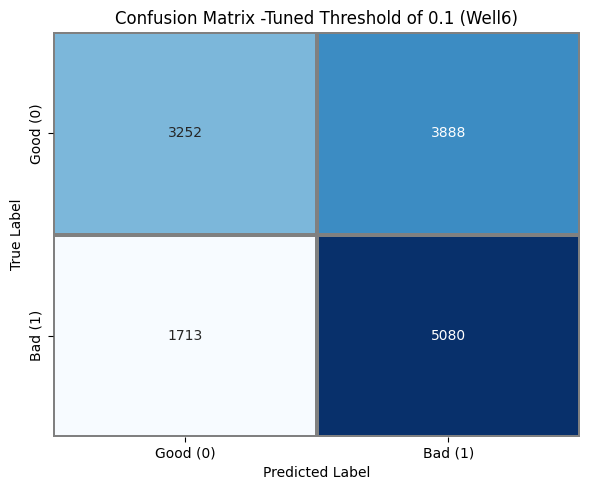

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix from your image after threshold tuning (0.1)
cm_thresh_01 = np.array([[3252, 3888],
                         [1713, 5080]])

# Define class labels
labels = ['Good (0)', 'Bad (1)']

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_thresh_01, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            linewidths=1.5, linecolor='gray', cbar=False)
plt.title('Confusion Matrix -Tuned Threshold of 0.1 (Well6)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


**Final Model Evaluation on Unseen Test Wells (WELLNUM 5 & 7)**

To assess the generalization ability of the trained XGBoost model, we conducted a final evaluation on WELLNUM 5 and 7, which were completely excluded from the training, validation, and tuning phases. This step serves as a robust test of real-world deployment, simulating how the model would perform on truly unseen wells.

Using the optimized hyperparameters and the selected classification threshold of 0.10, the model achieved the following results:


Precision for Bad: 0.90
Recall for Bad: 0.76
Overall accuracy: 0.77
Macro-averaged F1-score: 0.75

1. F1-score for Bad (1): 0.82
2. Precision for Bad: 0.90
3. Recall for Bad: 0.76
4. Overall accuracy: 0.77
5. Macro-averaged F1-score: 0.75

These results indicate that the model maintains strong performance on new wells, particularly in detecting bad-quality intervals, which is the primary objective of this study. The high precision ensures few false alarms, while the solid recall indicates the model captures a majority of poor-quality zones. The macro F1-score and accuracy further confirm balanced performance across both classes, despite the naturally imbalanced distribution (70% bad).

This final evaluation validates the robustness of the entire workflow—from outlier filtering and SMOTE balancing to hyperparameter tuning and threshold optimization—demonstrating the model’s practical potential for borehole quality control in real petrophysical workflows.

In [86]:
# Step 2: Compute RATIO = CALI / BS
hackathon_test['RATIO'] = hackathon_test['CALI'] / hackathon_test['BS']

# Step 3: Define QUALITY_FACTOR using your threshold rule
hackathon_test['QUALITY_FACTOR'] = hackathon_test['RATIO'].apply(
    lambda x: 0 if 0.98 <= x <= 1.02 else 1
)

# Step 4 (optional): Check proportion of BAD data
bad_ratio_test = (hackathon_test['QUALITY_FACTOR'] == 1).mean()
print(f"✅ Proportion of BAD data (test set): {bad_ratio_test:.4f}")

✅ Proportion of BAD data (test set): 0.6979


In [87]:
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Filter test wells 5 and 7
test_wells = [5, 7]
X_unseen = hackathon_test[hackathon_test['WELLNUM'].isin(test_wells)][features]
y_unseen = hackathon_test[hackathon_test['WELLNUM'].isin(test_wells)]['QUALITY_FACTOR']

# Step 2: Predict probabilities
y_unseen_proba = xgb_model.predict_proba(X_unseen)[:, 1]  # Prob for class 1 (Bad)

# Step 3: Apply threshold of 0.1
y_unseen_pred = (y_unseen_proba >= 0.1).astype(int)

# Step 4: Evaluate
print("📊 Confusion Matrix (WELLNUM 5 & 7, Threshold = 0.1):\n", confusion_matrix(y_unseen, y_unseen_pred))
print("\n📋 Classification Report (WELLNUM 5 & 7, Threshold = 0.1):\n", classification_report(y_unseen, y_unseen_pred, target_names=["Good (0)", "Bad (1)"]))


📊 Confusion Matrix (WELLNUM 5 & 7, Threshold = 0.1):
 [[ 772  192]
 [ 533 1694]]

📋 Classification Report (WELLNUM 5 & 7, Threshold = 0.1):
               precision    recall  f1-score   support

    Good (0)       0.59      0.80      0.68       964
     Bad (1)       0.90      0.76      0.82      2227

    accuracy                           0.77      3191
   macro avg       0.74      0.78      0.75      3191
weighted avg       0.81      0.77      0.78      3191



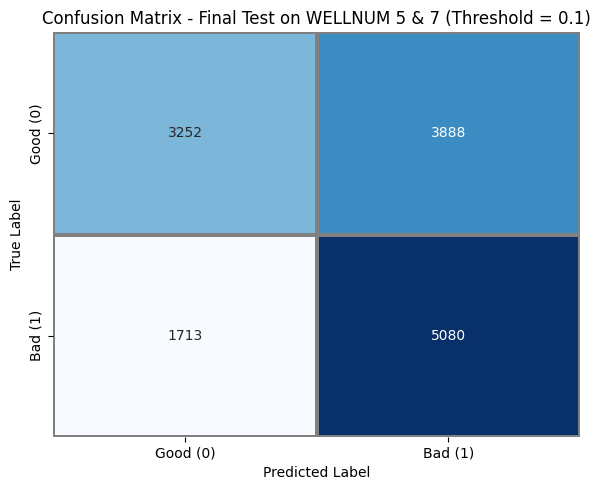

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace y_true and y_pred with your actual arrays
y_true = y_unseen  # True labels for wells 5 & 7
y_pred = y_unseen_pred  # Predicted labels from model at threshold = 0.1

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_thresh_01, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            linewidths=1.5, linecolor='gray', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Final Test on WELLNUM 5 & 7 (Threshold = 0.1)')
plt.tight_layout()
plt.show()


**Introduction to SHAP**

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to interpreting machine learning models. Based on Shapley values from cooperative game theory, SHAP attributes each feature’s contribution to the model prediction in a consistent and theoretically grounded way. This allows us to quantify how much each well log input (e.g., GR, DEN, NEU, RDEP) pushed the model’s prediction towards either a “good” or “bad” quality label. Unlike traditional feature importance which gives only global rankings, SHAP can explain individual predictions with precise directional contributions. In the context of well log data quality classification, this helps us move beyond “black-box” modeling and better align predictions with petrophysical understanding.

In [89]:
from xgboost import XGBClassifier

# Define and fit the best model again
best_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.025,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

best_model.fit(X_train_resampled, y_train_resampled)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:36:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

100%|===================| 38110/38224 [03:34<00:00]       

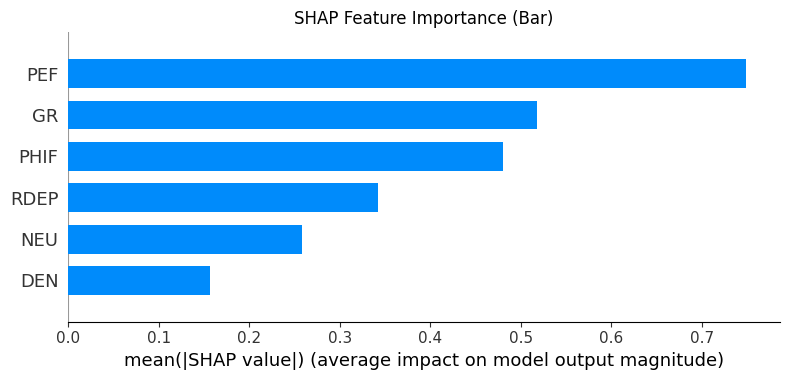

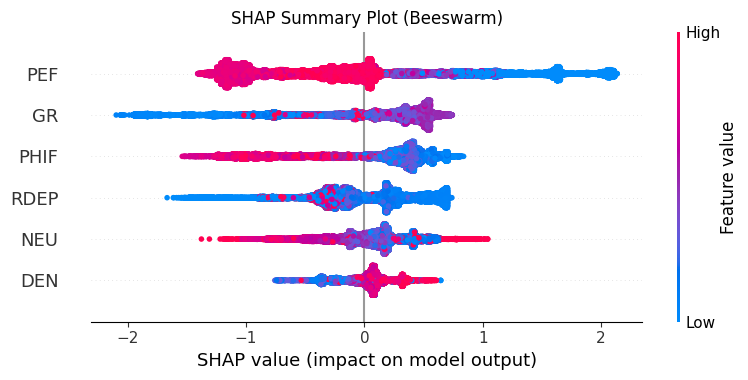

In [90]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer
explainer = shap.Explainer(best_model, X_train_resampled)

# Compute SHAP values
shap_values = explainer(X_train_resampled)

# Summary plot (bar)
plt.figure()
shap.summary_plot(shap_values, X_train_resampled, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar)")
plt.tight_layout()
plt.savefig(SAVE_DIR + "SHAP_feature_importance_bar.png", dpi=300)
plt.show()

# Summary plot (beeswarm)
plt.figure()
shap.summary_plot(shap_values, X_train_resampled, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.tight_layout()
plt.savefig(SAVE_DIR + "SHAP_summary_beeswarm.png", dpi=300)
plt.show()


The bar plot (Figure X) highlights the mean absolute SHAP values, which represent the average magnitude of contribution to the model output across all predictions. PEF (Photoelectric Factor) emerged as the most influential feature, followed closely by Gamma Ray (GR) and Porosity (PHIF). This aligns with domain knowledge, as borehole quality issues often correlate with lithological variations and porosity anomalies, both of which these logs capture.

The beeswarm plot (Figure Y) offers a more nuanced view, showing the direction of impact. For instance, high GR and low PEF values tend to increase the likelihood of a "Bad" classification (QUALITY_FACTOR = 1), confirming that the model captures petrophysically meaningful trends.

Overall, the SHAP analysis validates the integrity of the model by confirming that it relies on physically interpretable features, rather than learning from noise or spurious correlations.

In [91]:
import shap

# Step 1: Re-initialize TreeExplainer (for force plot compatibility)
explainer = shap.TreeExplainer(xgb_model)  # use your trained model name here

# Step 2: Choose a single example from the training set
sample = X_train_resampled.iloc[0]  # pick index 0 for illustration

# Step 3: Compute SHAP values for the whole set (or just one row if preferred)
shap_values = explainer.shap_values(X_train_resampled)

# Step 4: Initialize JS for interactive plot
shap.initjs()

# Step 5: Display force plot
shap.force_plot(explainer.expected_value, shap_values[0], sample)


**SHAP Force Plot: Local Feature Contributions**

To interpret individual model decisions, we applied SHAP's force plot on a single example from the SMOTE-resampled training set. This plot illustrates how each input feature pushes the model's prediction towards either the Bad (class 1) or Good (class 0) outcome.

In the selected instance:

PEF, GR, and DEN have strong negative SHAP values, pushing the prediction toward the Good class.

Conversely, PHIF, NEU, and RDEP push the prediction toward the Bad class, but their impact is smaller.

The overall SHAP value (~−0.08) lies closer to the base value, indicating the model is somewhat uncertain but slightly favors a Good prediction.

This visualization provides local interpretability, showing how model decisions are grounded in geophysically relevant inputs. It complements global feature importance charts by helping domain experts verify whether the model aligns with petrophysical expectations at the sample level.



Agreement Between Isolation Forest and QUALITY_FACTOR: 64.14%


/tmp/ipython-input-849262226.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AGREEMENT_LABEL', data=hackathon_train, palette='Set2')


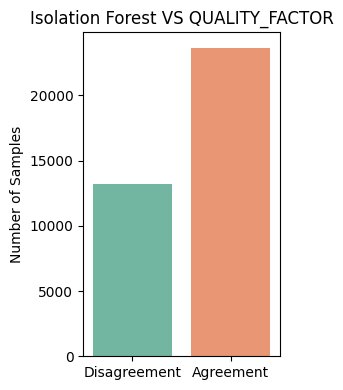

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create agreement column (1 if same, 0 if different)
hackathon_train['AGREEMENT'] = (hackathon_train['QUALITY_FACTOR'] == hackathon_train['IFOREST_OUTLIER']).astype(int)

# Step 2: Map to human-readable labels
hackathon_train['AGREEMENT_LABEL'] = hackathon_train['AGREEMENT'].map({1: 'Agreement', 0: 'Disagreement'})

# Step 3: Calculate percentage agreement
agreement_percent = hackathon_train['AGREEMENT'].mean() * 100
print(f"Agreement Between Isolation Forest and QUALITY_FACTOR: {agreement_percent:.2f}%")

# Step 4: Plot the agreement/disagreement count
plt.figure(figsize=(3, 4))
sns.countplot(x='AGREEMENT_LABEL', data=hackathon_train, palette='Set2')
plt.title("Isolation Forest VS QUALITY_FACTOR")
plt.ylabel("Number of Samples")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [93]:
print(hackathon_train.columns.tolist())


['WELLNUM', 'DEPTH', 'DTC', 'DTS', 'BS', 'CALI', 'DEN', 'DENC', 'GR', 'NEU', 'PEF', 'RDEP', 'RMED', 'ROP', 'PHIF', 'SW', 'VSH', 'RATIO', 'QUALITY_FACTOR', 'IFOREST_OUTLIER', 'AGREEMENT', 'AGREEMENT_LABEL']


/tmp/ipython-input-8044382.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AGREEMENT_LABEL', data=val_df, palette='Set2')


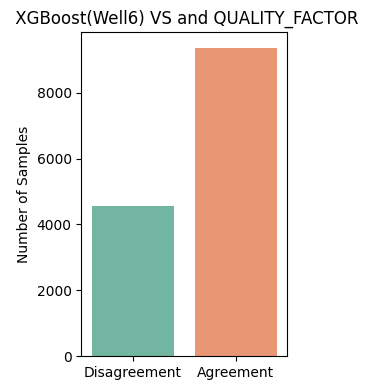


✅ Agreement between XGBoost and QUALITY_FACTOR on Well 6: 67.18%


In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 1. Predict probabilities on validation set (Well 6)
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]  # Probability of class 1 (Bad)

# 2. Apply threshold = 0.2
threshold = 0.2
xgb_pred_thresh = (y_val_proba >= threshold).astype(int)

# 3. Store predictions in the same dataframe (if not already done)
val_df = X_val.copy()
val_df['QUALITY_FACTOR'] = y_val  # true labels from Well 6
val_df['XGB_PREDICTION'] = xgb_pred_thresh

# 4. Compute agreement with baseline rule (QUALITY_FACTOR)
val_df['AGREEMENT'] = (val_df['QUALITY_FACTOR'] == val_df['XGB_PREDICTION']).astype(int)
val_df['AGREEMENT_LABEL'] = val_df['AGREEMENT'].map({1: 'Agreement', 0: 'Disagreement'})

# 5. Plot agreement
plt.figure(figsize=(3, 4))
sns.countplot(x='AGREEMENT_LABEL', data=val_df, palette='Set2')
plt.title(" XGBoost(Well6) VS and QUALITY_FACTOR")
plt.ylabel("Number of Samples")
plt.xlabel("")
plt.tight_layout()
plt.show()

# 6. Print percentage
agreement_pct = val_df['AGREEMENT'].mean() * 100
print(f"\n✅ Agreement between XGBoost and QUALITY_FACTOR on Well 6: {agreement_pct:.2f}%")


/tmp/ipython-input-3522866206.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AGREEMENT_LABEL', data=test_df, palette='Set2')


✅ Agreement between XGBoost and QUALITY_FACTOR on Wells 5 & 7: 77.28%


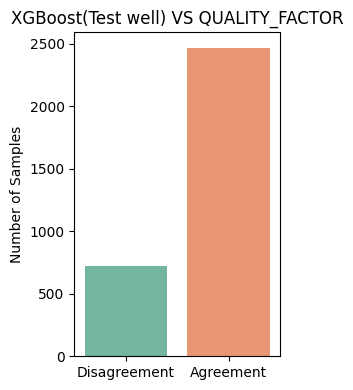

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create a DataFrame with test wells 5 & 7
test_wells = [5, 7]
test_df = hackathon_test[hackathon_test['WELLNUM'].isin(test_wells)].copy()

# Step 2: Predict probabilities and apply threshold
X_test = test_df[features]
y_test = test_df['QUALITY_FACTOR']
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]  # Class 1 = bad
test_df['XGB_PREDICTION'] = (y_test_proba >= 0.1).astype(int)

# Step 3: Compute agreement
test_df['AGREEMENT'] = (test_df['XGB_PREDICTION'] == test_df['QUALITY_FACTOR']).astype(int)
test_df['AGREEMENT_LABEL'] = test_df['AGREEMENT'].map({1: 'Agreement', 0: 'Disagreement'})

# Step 4: Calculate agreement percentage
agreement_ratio = test_df['AGREEMENT'].mean() * 100
print(f"✅ Agreement between XGBoost and QUALITY_FACTOR on Wells 5 & 7: {agreement_ratio:.2f}%")

# Step 5: Plot
plt.figure(figsize=(3, 4))
sns.countplot(x='AGREEMENT_LABEL', data=test_df, palette='Set2')
plt.title("XGBoost(Test well) VS QUALITY_FACTOR")
plt.ylabel("Number of Samples")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [96]:
import pandas as pd

# Step 1: Convert the probabilities to a DataFrame
conf_df = pd.DataFrame({'Prediction_Prob': y_unseen_proba})

# Step 2: Define confidence categories
def categorize_confidence(prob):
    if prob >= 0.9:
        return 'Very High (>=0.9)'
    elif prob >= 0.7:
        return 'High (0.7–0.89)'
    elif prob >= 0.5:
        return 'Medium (0.5–0.69)'
    elif prob >= 0.3:
        return 'Low (0.3–0.49)'
    else:
        return 'Very Low (<0.3)'

conf_df['Confidence_Level'] = conf_df['Prediction_Prob'].apply(categorize_confidence)

# Step 3: Count the number of predictions in each category
confidence_summary = conf_df['Confidence_Level'].value_counts().sort_index()

# Step 4: Display summary
print("📊 Prediction Confidence Distribution (Wells 5 & 7):\n")
print(confidence_summary)


📊 Prediction Confidence Distribution (Wells 5 & 7):

Confidence_Level
High (0.7–0.89)        65
Low (0.3–0.49)        635
Medium (0.5–0.69)     343
Very Low (<0.3)      2148
Name: count, dtype: int64


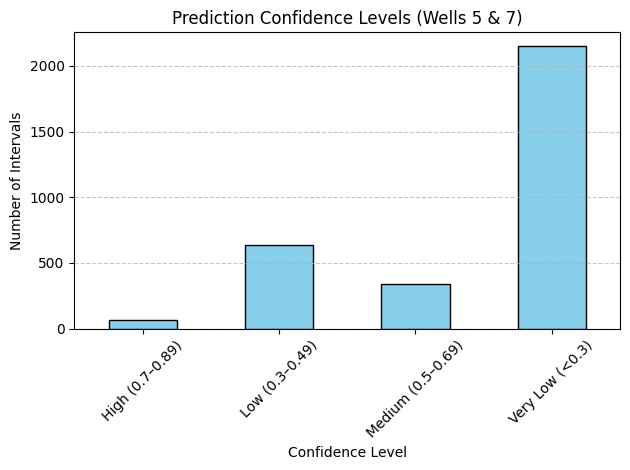

In [97]:
import matplotlib.pyplot as plt

# Plot the bar chart
confidence_summary.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Prediction Confidence Levels (Wells 5 & 7)")
plt.xlabel("Confidence Level")
plt.ylabel("Number of Intervals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


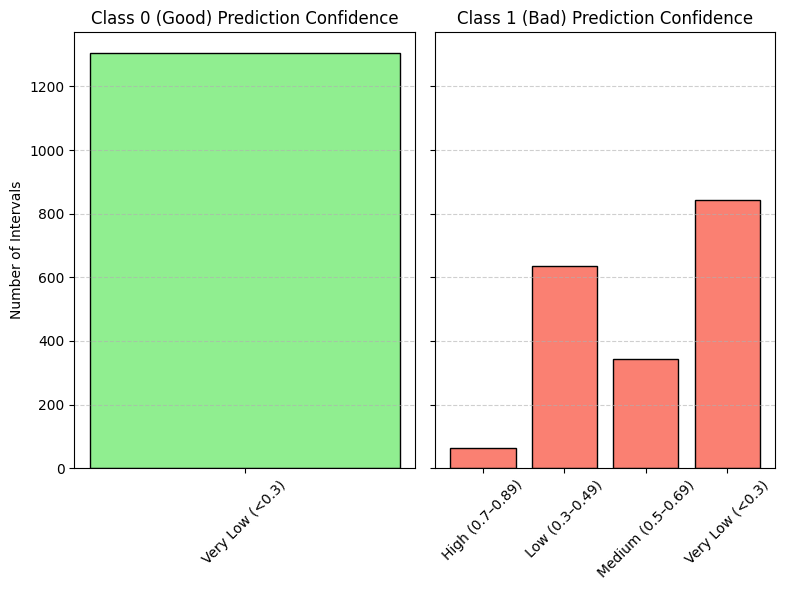

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Organize into DataFrame
df_conf = pd.DataFrame({
    'proba': y_unseen_proba,
    'predicted_label': y_unseen_pred
})

# Step 2: Define a function to bucket confidence scores
def label_confidence(prob):
    if prob >= 0.9:
        return "Very High (≥0.9)"
    elif prob >= 0.7:
        return "High (0.7–0.89)"
    elif prob >= 0.5:
        return "Medium (0.5–0.69)"
    elif prob >= 0.3:
        return "Low (0.3–0.49)"
    else:
        return "Very Low (<0.3)"

# Step 3: Apply to each class separately
df_conf['confidence_bucket'] = df_conf['proba'].apply(label_confidence)

# Separate into Class 0 and Class 1 predictions
class_0 = df_conf[df_conf['predicted_label'] == 0]
class_1 = df_conf[df_conf['predicted_label'] == 1]

# Count per confidence bucket
class_0_counts = class_0['confidence_bucket'].value_counts().sort_index()
class_1_counts = class_1['confidence_bucket'].value_counts().sort_index()

# Step 4: Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True)

# Class 0
axes[0].bar(class_0_counts.index, class_0_counts.values, color='lightgreen', edgecolor='black')
axes[0].set_title("Class 0 (Good) Prediction Confidence")

axes[0].set_ylabel("Number of Intervals")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Class 1
axes[1].bar(class_1_counts.index, class_1_counts.values, color='salmon', edgecolor='black')
axes[1].set_title("Class 1 (Bad) Prediction Confidence")

axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
